These notebooks are used to compare a base and scenario, from surveys or model outputs, in H5 format. To run: from the menu bar above, choose **Cell -> Run All ** or run lines individually. Use the toggle button below to hide/show the raw Python code.

 ## School and Workplace Location Models


    - Workplace Location
        - by County
        - by District
    - School Location
        - by County
        - by District
    - Workers Paying to Park at Work
        - by Workplace County
        - by Workplace District
    - Transit Pass Ownership
       - by Workplace County 
       - by Workplace District
       - by Home County 
       - by Home District
    - Auto Ownership
       - by County
       - by District
---

In [71]:
# Base run for comparison
base_run = r'R:\SoundCast\estimation\2014\P5\skims_attached'

# Scenario names
base_name = '2014 Survey'
scen_name = 'Soundcast'

# Base Year for Validation data
base_yr = 2014

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import numpy as np
import pandas as pd
import h5py
import pylab as P
from IPython.display import display, display_pretty, Javascript, HTML
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# Change working directory; only run this once since its a relative path change
default_path = r'../../../..'
os.chdir(default_path)

# Show charts in notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Load h5 or daysim outputs records
# Refering to 2 datasets as BASE and SCEN (scenario)

survey_loc = r'R:\SoundCast\estimation\2014\P5'

base = h5py.File(survey_loc + r'\survey14.h5','r+')
base_name = '2014 Survey'

# Note that expansion factor on daysim_outputs = 1 for each record, to allow direct comparison between survey records w/ exp. factor
scen = h5py.File(r'outputs\daysim_outputs.h5','r+')
scen_name = 'Daysim'

In [57]:
def build_df(h5file, h5table, fields, nested=False):
    '''return all fields from h5 table'''
    data = {}
    for field in fields:
        if nested:
            data[field] = [i[0] for i in h5file[h5table][field][:]]
        else:   
            data[field] = [i for i in h5file[h5table][field][:]]
        
    return pd.DataFrame(data)

In [ ]:
# Load trip, person, and household files from h5 files

In [106]:
trip_fields = ['dorp','dtaz','otaz','opurp','dpurp','mode','dpcl','opcl','arrtm','deptm','travdist','trexpfac']
trip_base = build_df(h5file=base, h5table='Trip', fields=trip_fields)
trip_scen = build_df(h5file=scen, h5table='Trip', fields=trip_fields)

In [112]:
person_fields = ['hhno','pno','ptpass','pwautime','pwaudist','pwtyp','pstyp','pwtaz','pstaz','pagey','pptyp','psexpfac']
person_scen = build_df(h5file=scen, h5table='Person', fields=person_fields)
person_base = build_df(h5file=base, h5table='Person', fields=person_fields)

In [287]:
# Create unique ID for person by concatenating household ID and person number 
person_scen['personID'] = (person_scen['Household ID'].astype('str')+person_scen['Person Number'].astype('str')).astype('int')
person_base['personID'] = (person_base['Household ID'].astype('str')+person_base['Person Number'].astype('str')).astype('int')

In [60]:
hh_fields = ['hhno','hhsize','hhvehs','hhwkrs','hhincome','hhtaz','hhexpfac']
hh_scen = build_df(h5file=scen, h5table='Household', fields=hh_fields)
hh_base = build_df(h5file=base, h5table='Household', fields=hh_fields)

In [289]:
hh_scen = build_df(h5file=scen, h5table='Household', var_dict=hhdict, nested=False)
hh_base = build_df(h5file=base, h5table='Household', var_dict=hhdict, nested=False)

In [114]:
# Join household records to person records
hh_per_scen = pd.merge(left=person_scen, right=hh_scen,on='hhno',suffixes=('_p','_h'))
hh_per_base = pd.merge(left=person_base, right=hh_base,on='hhno',suffixes=('_p','_h'))

In [115]:
# Join household geography
taz_geog = pd.read_csv(r'scripts/summarize/inputs/calibration/TAZ_TAD_County.csv')
taz_geog.reindex
hh_per_scen_home_geog = pd.merge(hh_per_scen, taz_geog, left_on='hhtaz', right_on='TAZ')
hh_per_base_home_geog = pd.merge(hh_per_base, taz_geog, left_on='hhtaz', right_on='TAZ')

In [116]:
# Join workplace geography
hh_per_scen_work_geog = pd.merge(hh_per_scen, taz_geog, left_on='pwtaz', right_on='TAZ')
hh_per_base_work_geog = pd.merge(hh_per_base, taz_geog, left_on='pwtaz', right_on='TAZ')

In [68]:
# Set some formatting options
pd.options.display.float_format = '{:.1f}%'.format    # set float format as percent, until further notice

In [79]:
def report_field(field, expfac, df_base, df_scen, title=None, figsize=(5,5)):
    '''print table summary of totals, distribution, and plot of distribution, for given field'''
    
    df = pd.DataFrame([df_base.groupby(field).sum()[expfac].astype('int'),
                   df_scen.groupby(field).sum()[expfac].astype('int')]).T
    df.columns=([scen_name,base_name])
    df.loc['Total'] = df.sum(axis=0)
    df['% Difference'] = ((df[scen_name] - df[base_name])/df[base_name])*100    # relative to base case
    
    print '--------Totals--------'
    print '' 
    print df
    
    print ''
    print ''
    print '-----Distribution-----'
    print ''

    
    df_new = pd.DataFrame([df[scen_name]/(df[scen_name].loc['Total']),
             df[base_name]/(df[base_name].loc['Total'])]).T*100
    df_new['% Difference'] = ((df_new[scen_name] - df_new[base_name])/df_new[base_name])*100    # relative to base case
    print df_new
    print ''
    df_new.drop(df_new.tail(1).index, inplace=True)    # do not plot totals columnn
    df_new[[scen_name,base_name]].plot(kind='bar', alpha=0.8, title=title, figsize=figsize)

---

## Workplace Location

### by County

--------Totals--------

           Soundcast  2014 Survey  % Difference
County                                         
King         1121029      1140109         -1.7%
Kitsap         79118       101795        -22.3%
Pierce        254531       285553        -10.9%
Snohomish     219565       258854        -15.2%
Total        1674243      1786311         -6.3%


-----Distribution-----

           Soundcast  2014 Survey  % Difference
County                                         
King           67.0%        63.8%          4.9%
Kitsap          4.7%         5.7%        -17.1%
Pierce         15.2%        16.0%         -4.9%
Snohomish      13.1%        14.5%         -9.5%
Total         100.0%       100.0%          0.0%



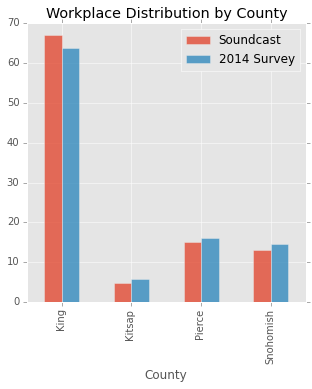

In [80]:
report_field(field='County', expfac='hhexpfac',
             df_base=hh_per_base_work_geog, 
             df_scen=hh_per_scen_work_geog, 
             title='Workplace Distribution by County')

### Workplace Location by District

--------Totals--------

                         Soundcast  2014 Survey  % Difference
New DistrictName                                             
East Side                   341627       331061          3.2%
Everett-Lynwood-Edmonds     134170       152032        -11.7%
Kitsap                       79118       101795        -22.3%
North Seattle-Shoreline     145550       142736          2.0%
Renton-FedWay-Kent          236524       288721        -18.1%
S.Kitsap                     14534        19895        -26.9%
Seattle CBD                 280301       247207         13.4%
South Pierce                122157       144052        -15.2%
Suburban Snohomish           85395       106822        -20.1%
Tacoma                      117838       121606         -3.1%
West-South Seattle          117025       130384        -10.2%
Total                      1674239      1786311         -6.3%


-----Distribution-----

                         Soundcast  2014 Survey  % Difference
New DistrictName    

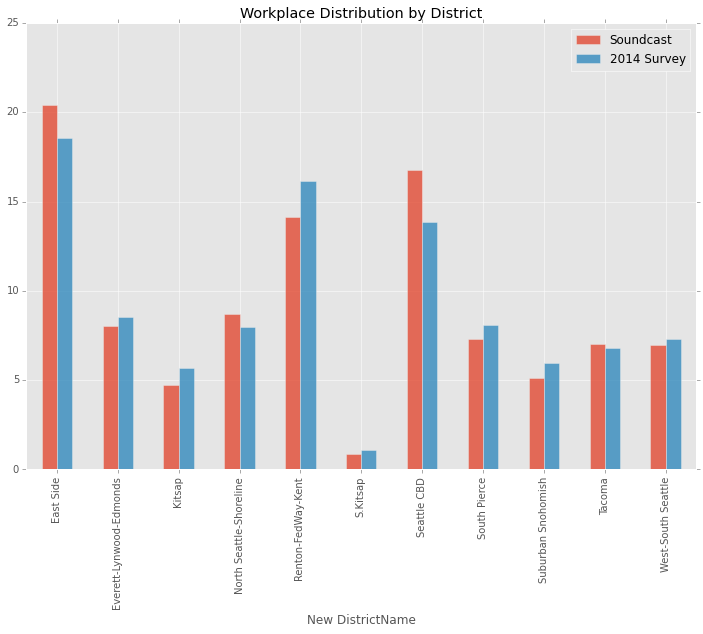

In [82]:
report_field('New DistrictName', expfac='hhexpfac',
             df_base=hh_per_base_work_geog, 
             df_scen=hh_per_scen_work_geog, 
             title='Workplace Distribution by District', figsize=(12,8))

## Distance to Work

In [100]:
# Select all home -> work and work -> trips
def get_work_trips(df):
    
    # home to work trips
    work2home = df[df['opurp'] == 1]    # select all work destination
    work2home = work2home[work2home['dpurp'] == 0]    # select all home origins

    # work to home trips
    home2work = df[df['opurp'] == 0]    # select all work destination
    home2work = home2work[home2work['dpurp'] == 1]   # select all home origins

    # all work trips
    work_trips = work2home.append(home2work)
    
    return work_trips

In [101]:
def wt_mean(df, measure_col, weight_col, groupby_field=None):
    '''Compute weighted statistic for a dataframe'''
    
    if groupby_field:
        df['weighted'] = df[measure_col]*df[weight_col]
        result_df = df.groupby(groupby_field).sum()['weighted']/df.sum()[weight_col]
    else:
        result_df = (df[measure_col]*df[weight_col]).sum()/df[weight_col].sum()
    
    return result_df

In [102]:
pd.options.display.float_format = '{:.1f}'.format 

In [107]:
work_trips_base = get_work_trips(trip_base)
work_trips_scen = get_work_trips(trip_scen)

In [108]:
# Exclude all -1 trips
work_trips_base = work_trips_base[work_trips_base['travdist'] > 0]
work_trips_scen = work_trips_scen[work_trips_scen['travdist'] > 0]

** Average Distance to Work/Home**

In [110]:
print base_name + ": " + str(wt_mean(df=work_trips_base, 
                                     measure_col='travdist', 
                                     weight_col='trexpfac')/100)
print scen_name + ": " + str(wt_mean(df=work_trips_scen, 
                                     measure_col='travdist', 
                                     weight_col='trexpfac'))

2014 Survey: 11.7616553021
Soundcast: 13.489142888


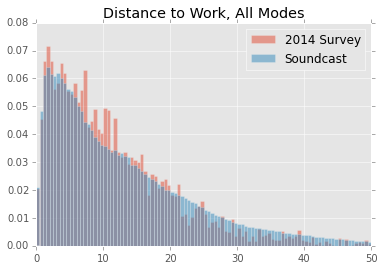

In [111]:
(work_trips_base['travdist']/100).hist(bins=100, normed=True,
                                              weights=work_trips_base['trexpfac'].values,
                                             alpha=0.5, range=[0,50],
                                             label=base_name)

work_trips_scen['travdist'].hist(bins=100, normed=True, 
                                        alpha=0.5, range=[0,50],
                                       label=scen_name)

pyplot.legend(loc='upper right')
pyplot.title('Distance to Work, All Modes')

---

## School Location

In [117]:
# Join school geography
hh_per_scen_school_geog = pd.merge(hh_per_scen, taz_geog, left_on='pstaz', right_on='TAZ')
hh_per_base_school_geog = pd.merge(hh_per_base, taz_geog, left_on='pstaz', right_on='TAZ')

### By County

--------Totals--------

           Soundcast  2014 Survey  % Difference
County                                         
King          692792       509961          35.9
Kitsap         63814        64244          -0.7
Pierce        239216       208352          14.8
Snohomish     187979       189855          -1.0
Total        1183801       972412          21.7


-----Distribution-----

           Soundcast  2014 Survey  % Difference
County                                         
King            58.5         52.4          11.6
Kitsap           5.4          6.6         -18.4
Pierce          20.2         21.4          -5.7
Snohomish       15.9         19.5         -18.7
Total          100.0        100.0           0.0



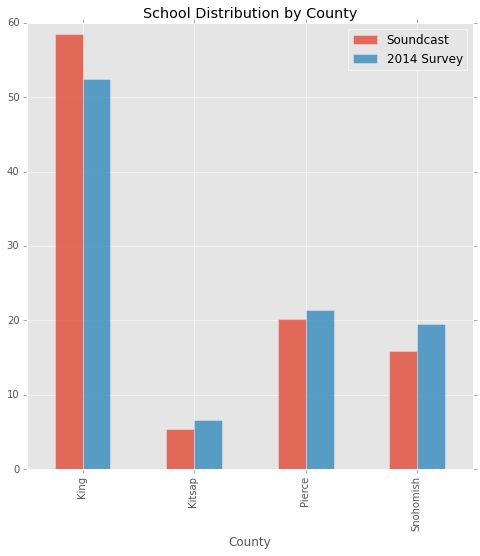

In [120]:
report_field(field='County', expfac='psexpfac',
             df_base=hh_per_base_school_geog, 
             df_scen=hh_per_scen_school_geog, 
             title='School Distribution by County', figsize=(8,8))

### School Location by District

--------Totals--------

                         Soundcast  2014 Survey  % Difference
New DistrictName                                             
East Side                   239550       165228          45.0
Everett-Lynwood-Edmonds      89072        74502          19.6
Kitsap                       63814        64244          -0.7
North Seattle-Shoreline     156919        78851          99.0
Renton-FedWay-Kent          135589       161415         -16.0
S.Kitsap                     14677        13659           7.5
Seattle CBD                 102559        49515         107.1
South Pierce                149147       128679          15.9
Suburban Snohomish           98907       115353         -14.3
Tacoma                       75392        66014          14.2
West-South Seattle           58174        54952           5.9
Total                      1183800       972412          21.7


-----Distribution-----

                         Soundcast  2014 Survey  % Difference
New DistrictName    

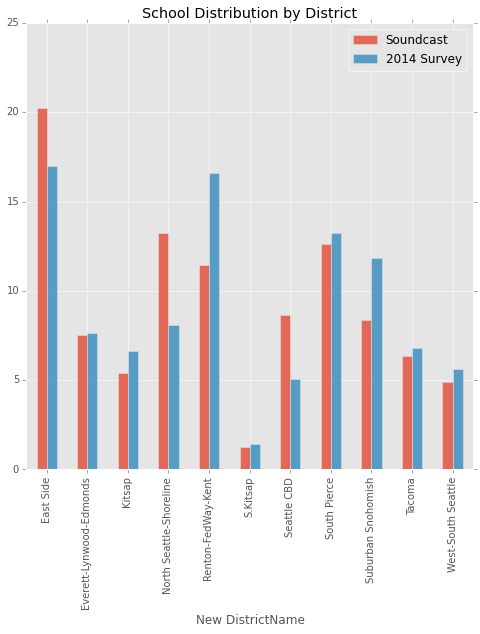

In [125]:
report_field(field='New DistrictName', expfac='psexpfac',
             df_base=hh_per_base_school_geog, 
             df_scen=hh_per_scen_school_geog, 
             title='School Distribution by District', figsize=(8,8))

# Transit Pass Ownership

In [126]:
# 2014 survey has multiple fields for transit pass ownership. Sum all non-zero fields into 1, for yes/no

# Drop -1 (no answer rows for transit pass)
df_pass_base_home = hh_per_base_home_geog[hh_per_base_home_geog['ptpass'] >= 0]
df_pass_base_work = hh_per_base_work_geog[hh_per_base_work_geog['ptpass'] >= 0]

# Convert categorical responses (different pass types) to binary yes/no
df_pass_base_home['ptpass'] = df_pass_base_home['ptpass'].apply(lambda x: 1 if x >=1 else 0)
df_pass_base_work['ptpass'] = df_pass_base_work['ptpass'].apply(lambda x: 1 if x >=1 else 0)

C:\Users\Brice\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Brice\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Region Wide

--------Totals--------

        Soundcast  2014 Survey  % Difference
ptpass                                      
0         2299667      3088967         -25.6
1          467002       507572          -8.0
Total     2766669      3596539         -23.1


-----Distribution-----

        Soundcast  2014 Survey  % Difference
ptpass                                      
0            83.1         85.9          -3.2
1            16.9         14.1          19.6
Total       100.0        100.0           0.0



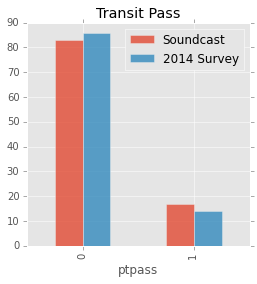

In [128]:
report_field('ptpass', expfac='psexpfac',
             df_base=df_pass_base_home, 
             df_scen=hh_per_scen_home_geog, 
             title='Transit Pass', figsize=(4,4))

## By Home County

In [140]:
def transit_pass(df_base, expfac, df_scen, geography, title=None):
    df_result = pd.DataFrame()

    # base
    df = pd.pivot_table(data=df_base, columns=['ptpass'], index=geography, 
                   values=expfac, aggfunc='sum').astype('int')
    df_result[base_name] = (df[1]/df.sum(axis=1))*100
    df_result

    # scenario
    df = pd.pivot_table(data=df_scen, columns=['ptpass'], index=geography, 
                   values=expfac, aggfunc='sum').astype('int')
    df_result[scen_name] = (df[1]/df.sum(axis=1))*100
    
    print df_result
    print ""
    print "--------------------------"
    print ""
    print df_result.plot(kind='bar', title=title, alpha=0.8)

           2014 Survey  Soundcast
County                           
King              22.1       17.1
Kitsap            17.5        7.0
Pierce             8.4       10.8
Snohomish         11.0       12.2

--------------------------

Axes(0.125,0.125;0.775x0.775)


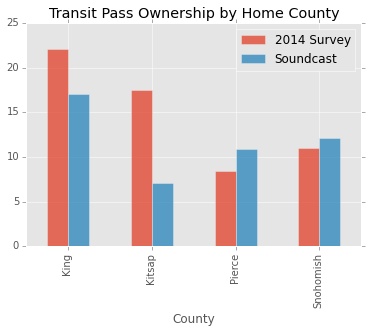

In [141]:
transit_pass(df_base=df_pass_base_home, expfac='hhexpfac',
             df_scen=hh_per_scen_home_geog, 
             geography='County', title='Transit Pass Ownership by Home County')

                         2014 Survey  Soundcast
New DistrictName                               
East Side                       17.5       12.2
Everett-Lynwood-Edmonds         14.3       15.7
Kitsap                          17.5        7.0
North Seattle-Shoreline         31.3       23.9
Renton-FedWay-Kent              10.1       12.3
S.Kitsap                         5.9        5.8
Seattle CBD                     38.7       34.5
South Pierce                     6.0        9.5
Suburban Snohomish               8.9       10.0
Tacoma                          13.5       14.9
West-South Seattle              32.4       19.5

--------------------------

Axes(0.125,0.125;0.775x0.775)


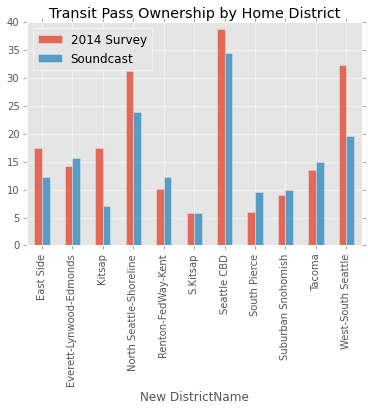

In [142]:
transit_pass(df_base=df_pass_base_home, expfac='hhexpfac',
             df_scen=hh_per_scen_home_geog, 
             geography='New DistrictName', title='Transit Pass Ownership by Home District')

### By Work Location

## County Work Location

           2014 Survey  Soundcast
County                           
King              29.9       22.5
Kitsap            18.0        5.1
Pierce             6.6        8.8
Snohomish          8.4        8.3

--------------------------

Axes(0.125,0.125;0.775x0.775)


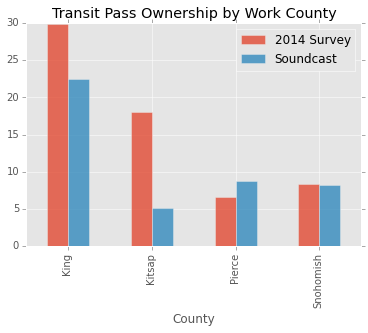

In [143]:
transit_pass(df_base=df_pass_base_work, expfac='hhexpfac',
             df_scen=hh_per_scen_work_geog, 
             geography='County', title='Transit Pass Ownership by Work County')

## by Work District

                         2014 Survey  Soundcast
New DistrictName                               
East Side                       18.4       14.7
Everett-Lynwood-Edmonds         10.5       11.1
Kitsap                          18.0        5.1
North Seattle-Shoreline         33.2       23.7
Renton-FedWay-Kent              11.7       11.5
S.Kitsap                         4.4        5.3
Seattle CBD                     57.7       47.0
South Pierce                     2.5        5.3
Suburban Snohomish               5.2        4.1
Tacoma                          11.1       13.6
West-South Seattle              29.9       19.2

--------------------------

Axes(0.125,0.125;0.775x0.775)


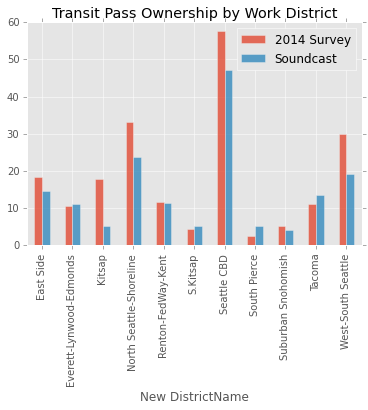

In [145]:
transit_pass(df_base=df_pass_base_work, expfac='hhexpfac',
             df_scen=hh_per_scen_work_geog, 
             geography='New DistrictName', title='Transit Pass Ownership by Work District')

---

# Auto Ownership

In [147]:
print 'Vehicles per Household'
df = pd.DataFrame([(hh_scen.groupby('hhvehs').sum()['hhexpfac']),
                   hh_base.groupby('hhvehs').sum()['hhexpfac']]).T
df.columns=([scen_name,base_name])
df.fillna(0,inplace=True)
df[scen_name] = df[scen_name].astype('int')
df[base_name] = df[base_name].astype('int')
df

Vehicles per Household


,Soundcast,2014 Survey
hhvehs,,
0,110375,116720
1,421679,477848
2,562190,560222
3,240517,218361
4,114591,72856
5,0,22097
6,0,2295
7,0,4625
8,0,1874


In [148]:
print 'Distribution of Vehilces per Household'
df_new = pd.DataFrame([df[scen_name]/df[scen_name].sum(),
             df[base_name]/df[base_name].sum()]).T*100
df_new

Distribution of Vehilces per Household


,Soundcast,2014 Survey
hhvehs,,
0,7.6,7.9
1,29.1,32.3
2,38.8,37.9
3,16.6,14.8
4,7.9,4.9
5,0.0,1.5
6,0.0,0.2
7,0.0,0.3
8,0.0,0.1


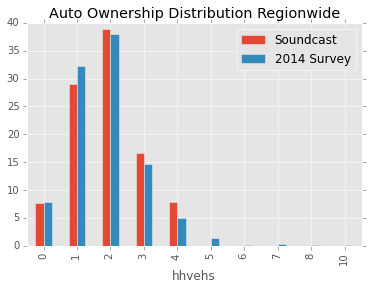

In [149]:
df_new.plot(kind='bar', title='Auto Ownership Distribution Regionwide')

In [150]:
# Average autos per household
print scen_name + ": " + str(sum(hh_scen['hhvehs']*hh_scen['hhexpfac'])/sum(hh_scen['hhexpfac']))
print base_name + ": " + str(sum(hh_base['hhvehs']*hh_base['hhexpfac'])/sum(hh_base['hhexpfac']))

Soundcast: 1.8808226021
2014 Survey: 1.84776763947


In [151]:
# Auto Ownership by Income
# Create common income ranges
def map_income(df, in_field, out_field):
    
    # Define categories
    incmap = {}
    for i in range(0, 20000):
        incmap.update({i: ' <20k'})
    for i in range(20000, 40000):
        incmap.update({i: '20k-40k'})
    for i in range(40000, 60000):
        incmap.update({i: '40k-60k'})
    for i in range(60000, 75000):
        incmap.update({i: '60k-75k'})
    for i in range(75000, 100000):
        incmap.update({i: '75k-100k'})
    for i in range(100000, 150000):
        incmap.update({i: '100k-150k'})
    for i in range(150000, int(df[in_field].max())+1):
        incmap.update({i: '>150k'})

    df[out_field] = df[in_field].map(incmap)
    return df

In [200]:
hh_scen = map_income(hh_scen, in_field='hhincome', out_field='Income')
hh_base = map_income(hh_base, in_field='hhincome', out_field='Income')

In [201]:
df_scen = pd.pivot_table(data=hh_scen, index='hhvehs', columns='Income', values='hhexpfac', aggfunc='sum')
df_base = pd.pivot_table(data=hh_base, index='hhvehs', columns='Income', values='hhexpfac', aggfunc='sum')
# # Sort the columns
df_scen = df_scen[[' <20k','20k-40k','40k-60k','60k-75k',
                   '75k-100k','100k-150k','>150k']]
df_base = df_base[[' <20k','20k-40k','40k-60k','60k-75k',
                   '75k-100k','100k-150k','>150k']]

In [213]:
pd.options.display.float_format = '{:.1f}'.format    # set float format as percent, until further notice

In [214]:
# Calculate averages by income class
df = pd.DataFrame([[sum(df_scen[colname]*df_scen.index)/sum(df_scen[colname]) for colname in df_scen.columns],
                    [sum(df_base[colname]*df_base.index)/sum(df_base[colname]) for colname in df_base.columns]]).T
df.index=df_base.columns
df.columns=[scen_name,base_name]
# df[scen_name] = df[scen_name].astype('int')
# df[base_name] = df[base_name].astype('int')
df['% difference 2006->2014']= (df[base_name]-df[scen_name])/df[scen_name]
df

,Soundcast,2014 Survey,% difference 2006->2014
Income,,,
<20k,1.0,1.0,0.0
20k-40k,1.5,1.4,-0.1
40k-60k,1.7,1.6,-0.1
60k-75k,2.1,1.9,-0.1
75k-100k,2.3,2.2,-0.0
100k-150k,2.4,2.4,-0.0
>150k,2.4,2.6,0.1


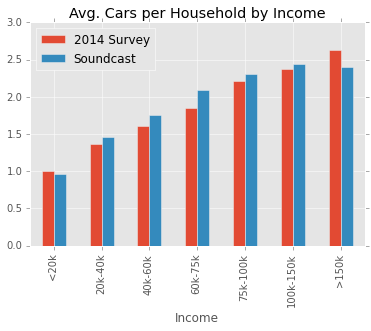

In [217]:
df[[base_name, scen_name]].plot(kind='bar', title='Avg. Cars per Household by Income')